### ライブラリ・自作パッケージをインポート

In [ ]:
import os
import math
import pprint
import copy

import numpy as np
import matplotlib.pyplot as plt

if os.getcwd() == "/content":   # 作業ディレクトリがGoogle Driveなら実行
  from google.colab import drive
  drive.mount("/content/drive")   # Google Driveをマウント
  os.chdir("/content/drive/MyDrive/Colab Notebooks")    #作業ディレクトリを移動

import PDApkg as pda

### シミュレーションパラメータ設定

In [2]:
# if (__name__ == '__main__'):

SIM = pda.Storage()

### モード
# NN変調器
SIM.use_nnmod = True
# ASB
# SIM.ASB_mode = 'none'
# SIM.ASB_mode = 'ASB'
SIM.ASB_mode = 'DU'

### 送受信機共通設定
# 送受信アンテナ本数
SIM.M = 16
SIM.N = 16
# 変調多値数 (QAMのみ)
SIM.Q_ant = 64
SIM.Q_dim = int(math.sqrt(SIM.Q_ant)) #
# シンボル長
SIM.Kd = 100
# 結合アンテナ本数 (0.5 or 1)
SIM.num_joint_ant = 1

### 受信機設定
# 繰り返し回数
SIM.niter_PDA = 16
# ASB (初期値)
SIM.d1 = 0.2
SIM.d2 = 1.0

### 訓練パラメータ
## 共通訓練条件
SIM.epochs = int(1e3)
SIM.mbs = 1
SIM.EsN0_train = 35
## 変調器
# 構造
SIM.hidden_depth = 1 #
SIM.hidden_dim = 32 #
SIM.ind_cons = False
# 訓練条件
SIM.lr_mod = 1e-4
SIM.drop_start_mod = 0
SIM.drop_factor_mod = 1
## 検出器
SIM.lr_det = 1e-3
SIM.drop_start_det = 0
SIM.drop_factor_det = 1

### テスト設定
# Es/N0
SIM.EsN0_test = np.arange(20, 50 + 1, 2)
# ループ数（注意：1workerあたりのSE_maxが小さいと誤差がでやすくなる）
SIM.nloop_max = 1e2
SIM.SE_max = 1e4 #

### 実行環境
SIM.env_server = '\\nas001\share' in os.getcwd() # 実行環境が研究室サーバーかどうか
SIM.nworker = 50

### 表示
pprint.pprint(SIM.__dict__, sort_dicts=False)

{'use_nnmod': True,
 'ASB_mode': 'DU',
 'M': 16,
 'N': 16,
 'Q_ant': 64,
 'Q_dim': 8,
 'Kd': 100,
 'num_joint_ant': 1,
 'niter_PDA': 16,
 'd1': 0.2,
 'd2': 1.0,
 'epochs': 1000,
 'mbs': 1,
 'EsN0_train': 35,
 'hidden_depth': 1,
 'hidden_dim': 32,
 'ind_cons': False,
 'lr_mod': 0.0001,
 'drop_start_mod': 0,
 'drop_factor_mod': 1,
 'lr_det': 0.001,
 'drop_start_det': 0,
 'drop_factor_det': 1,
 'EsN0_test': array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]),
 'nloop_max': 100.0,
 'SE_max': 10000.0,
 'env_server': False,
 'nworker': 50}


### MMSEで訓練

In [3]:
if SIM.use_nnmod:
    # 訓練条件設定
    SIM_pre = copy.deepcopy(SIM)
    SIM_pre.ASB_mode = 'none'
    SIM_pre.niter_PDA = 1
    SIM_pre.epochs = 1000
    SIM_pre.mbs = 1
    SIM_pre.EsN0_train = 35
    SIM_pre.lr_mod = 0.001
    SIM_pre.drop_start_mod = 100
    SIM_pre.drop_factor_mod = 0.995
    # 訓練実行
    RES_train = pda.train_model(SIM_pre)
    print(RES_train.time)

0 100 200 300 400 500 600 700 800 900 
9.348376299953088


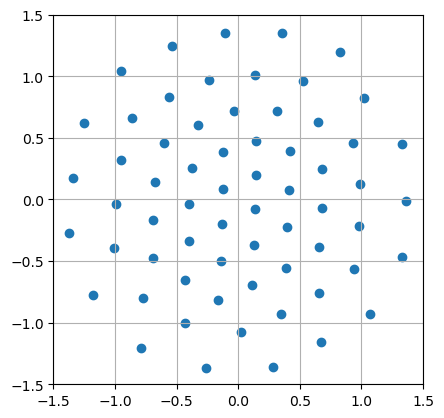

In [4]:
# コンスタレーション表示
if (not SIM.env_server) and SIM.use_nnmod:
    m = 0
    lim = 1.5
    x_rep = RES_train.nnmod.x_rep.detach().numpy()
    if SIM.num_joint_ant == 0.5:
        plt.scatter(x_rep[m], np.zeros(SIM.Q_dim))
    elif SIM.num_joint_ant == 1:
        plt.scatter(x_rep[m], x_rep[SIM.M+m])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.show()
    # m += 1

### PDAで訓練

0 100 200 300 400 500 600 700 800 900 
486.7474668000359


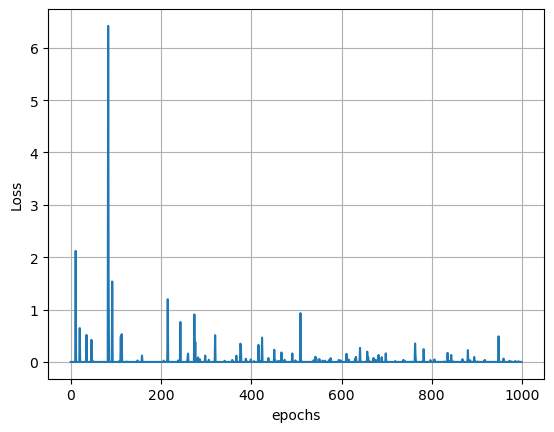

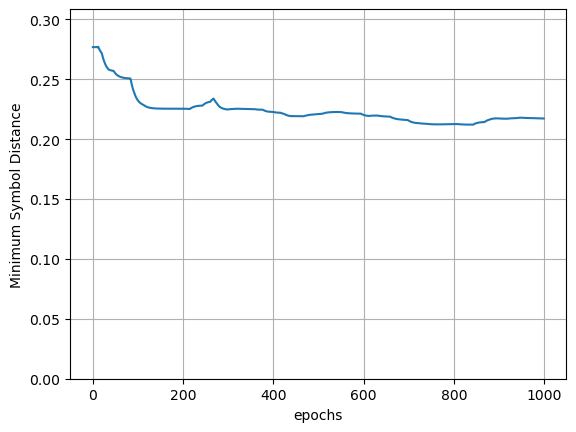

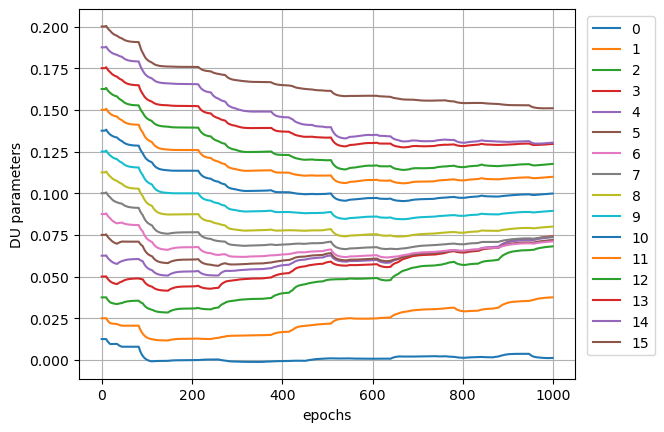

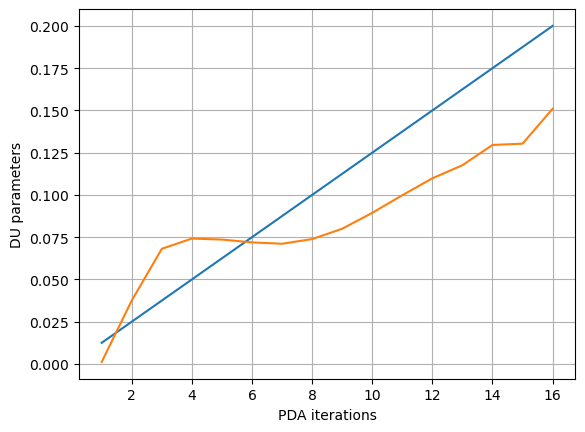

In [5]:
if SIM.use_nnmod or (SIM.ASB_mode == 'DU'):
    ### 訓練実行
    nnmod = RES_train.nnmod if SIM.use_nnmod else None
    RES_train = pda.train_model(SIM, nnmod)
    print(RES_train.time)
    ### グラフ表示
    if not SIM.env_server:
        # 損失値
        plt.plot(RES_train.loss)
        plt.grid()
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        plt.show()
        # NN変調器
        if SIM.use_nnmod:
            # 最小シンボル間距離
            plt.plot(RES_train.dist)
            plt.grid()
            plt.ylim(0, math.sqrt(6 / (SIM.Q_ant - 1)))
            plt.xlabel("epochs")
            plt.ylabel("Minimum Symbol Distance")
            plt.show()
        # DU検出器
        if SIM.ASB_mode == 'DU':
            # 深層展開パラメータ 学習経過
            for idx_iter in range(SIM.niter_PDA):
                plt.plot(RES_train.DU[:,idx_iter], label=idx_iter)
            plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
            plt.grid()
            plt.xlabel("epochs")
            plt.ylabel("DU parameters")
            # plt.yscale("log")
            plt.show()
            # 深層展開パラメータ 初期値と結果値
            k = np.arange(1, SIM.niter_PDA+1)
            plt.plot(k, SIM.d1*(k/SIM.niter_PDA)**SIM.d2)
            plt.plot(k, RES_train.DU[-1])
            plt.grid()
            plt.xlabel("PDA iterations")
            plt.ylabel("DU parameters")
            # plt.xscale("log")
            # plt.yscale("log")
            plt.show()

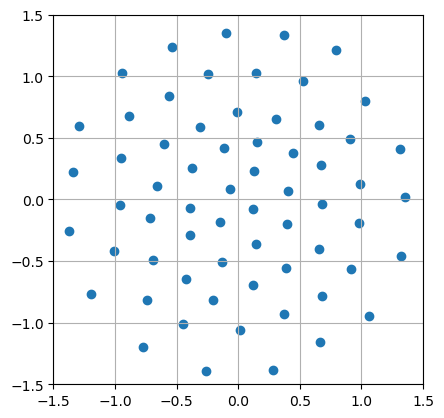

In [6]:
# コンスタレーション表示
if (not SIM.env_server) and SIM.use_nnmod:
    m = 0
    lim = 1.5
    x_rep = RES_train.nnmod.x_rep.detach().numpy()
    if SIM.num_joint_ant == 0.5:
        plt.scatter(x_rep[m], np.zeros(SIM.Q_dim))
    elif SIM.num_joint_ant == 1:
        plt.scatter(x_rep[m], x_rep[SIM.M+m])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.show()
    m += 1

### テスト

20 dB, nloop = 100 , noe = [285701   9996] , ER = [0.2976 0.9995] , 5.516 sec, 5.516 sec
22 dB, nloop = 100 , noe = [244648   9955] , ER = [0.255  0.9956] , 4.93 sec, 10.445 sec
24 dB, nloop = 100 , noe = [191697   9751] , ER = [0.1997 0.975 ] , 4.617 sec, 15.06 sec
26 dB, nloop = 100 , noe = [146143   9175] , ER = [0.1522 0.9175] , 5.09 sec, 20.16 sec
28 dB, nloop = 100 , noe = [106388   7461] , ER = [0.11084 0.746  ] , 5.2 sec, 25.34 sec
30 dB, nloop = 100 , noe = [61427  4669] , ER = [0.06396 0.4668 ] , 4.8 sec, 30.14 sec
32 dB, nloop = 100 , noe = [19028  1408] , ER = [0.01982 0.1407 ] , 4.965 sec, 35.12 sec
34 dB, nloop = 100 , noe = [3161  188] , ER = [0.003292 0.0188  ] , 5.484 sec, 40.6 sec
36 dB, nloop = 100 , noe = [289  11] , ER = [0.0003011 0.0011   ] , 5.965 sec, 46.56 sec
38 dB, nloop = 100 , noe = [44  1] , ER = [4.584e-05 1.000e-04] , 5.723 sec, 52.28 sec
40 dB, nloop = 100 , noe = [51  1] , ER = [5.31e-05 1.00e-04] , 5.79 sec, 58.06 sec
42 dB, nloop = 100 , noe = [0 0]

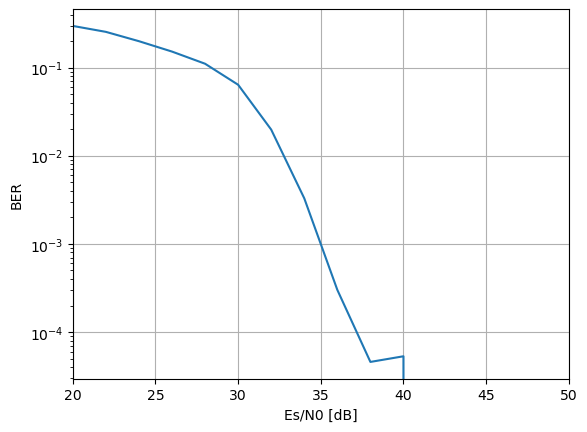


SER
0.9996
0.9955
0.9751
0.9175
0.7461
0.4669
0.1408
0.0188
0.0011
0.0001
0.0001
0.0
0.0
0.0
0.0
0.0


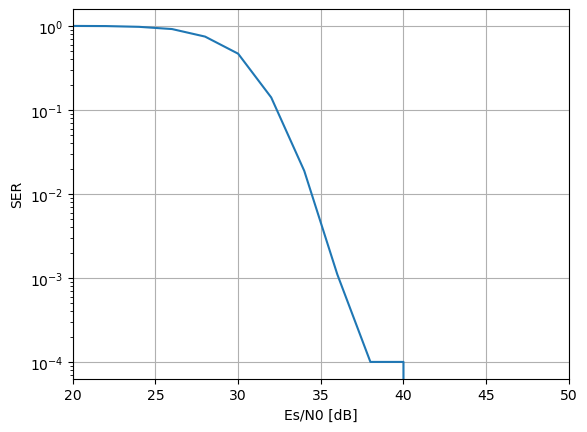

In [7]:
### テスト実行
nnmod = RES_train.nnmod if SIM.use_nnmod else None
DU_param = RES_train.DU[-1] if SIM.ASB_mode == 'DU' else None
RES_test = pda.test_model(SIM, nnmod, DU_param)
print()

### BER特性
# 数値表示
print('BER')
for ber in RES_test.BER:
    print(ber)
# グラフ表示
if not SIM.env_server:
    plt.plot(SIM.EsN0_test, RES_test.BER)
    plt.grid()
    plt.xlabel("Es/N0 [dB]")
    plt.ylabel("BER")
    plt.xlim([SIM.EsN0_test[0], SIM.EsN0_test[-1]])
    plt.yscale("log")
    plt.show()
print()

### SER特性
# 数値表示
print('SER')
for ser in RES_test.SER:
    print(ser)
# グラフ表示
if not SIM.env_server:
    plt.plot(SIM.EsN0_test, RES_test.SER)
    plt.grid()
    plt.xlabel("Es/N0 [dB]")
    plt.ylabel("SER")
    plt.xlim([SIM.EsN0_test[0], SIM.EsN0_test[-1]])
    plt.yscale("log")
    plt.show()
print()